## Imports

In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize
# from impedance.models.circuits import CustomCircuit
# from impedance.visualization import plot_nyquist # Kept if you want to switch plotting methods

import os
from os import listdir
from os.path import isfile, join


## Data Loading functions

In [90]:
# --- Data Loading ---
def EIS_z60_import(filename):
    """ Import z60 file as pandas dataframe."""
    df = pd.read_csv(
        filename,
        skiprows=11,
        sep=r'\s+',
        header=None,
        names=["Freq", "Ampl", "Bias", "Time", "Z'", "Z''", "GD", "Err", "Range"],
        index_col="Freq")

    df = df.drop(columns=['Ampl', 'Bias', 'Time', 'GD', 'Err', 'Range']) # Drop columns
    mask = (df["Z'"] > 0) & (df["Z''"] < 0) # Only keep first quadrant in Nyquist plot

    df['Z'] = np.sqrt( (df["Z'"].to_numpy())**2 + \
                       (df["Z'"].to_numpy())**2 )

    df['theta'] = np.arctan2(-df["Z'"].to_numpy(), df["Z''"].to_numpy()) * 180 / np.pi
    
    df[~mask] = None
    return df

In [91]:
EIS_z60_import("EIS_10mV_Timing task2025_07_11_17_19_C001.z60")

Z'        Z''             Z       theta
Freq                                                        
100000.000000       NaN        NaN           NaN         NaN
89051.300000        NaN        NaN           NaN         NaN
79301.400000        NaN        NaN           NaN         NaN
70618.900000        NaN        NaN           NaN         NaN
62887.000000        NaN        NaN           NaN         NaN
...                 ...        ...           ...         ...
0.014616       676330.0  -564709.0  9.564751e+05 -129.860556
0.013016       607638.0  -414233.0  8.593299e+05 -124.282652
0.011591       814114.0  -698537.0  1.151331e+06 -130.630696
0.010322       848202.0  -689490.0  1.199539e+06 -129.107116
0.010000       720312.0 -1031530.0  1.018675e+06 -145.073605

[140 rows x 4 columns]

## Loading all files from timed repeated measurements

In [92]:
import os
from os import listdir
from os.path import isfile, join


EIS_10 = [file 
          for file in os.listdir('.') 
          if file.startswith('EIS_10mV') and file.endswith('.z60')]
EIS_10_df_list = [] # 1. Create an empty list to hold the DataFrames
for filename in EIS_10:
    base_name = filename.removesuffix('.z60')
    repeat_number = "".join(char for char in base_name.rsplit('_', 1)[-1] if char.isdigit())
    repeat_number = int(repeat_number) 
    time = (repeat_number - 1)*2
    #print(f"{base_name}  {time}")
    df = EIS_z60_import(filename)
    df["Time"] = time
    df.set_index('Time', append=True, inplace=True)    
    df_swapped = df.swaplevel()
    df_sorted = df_swapped.sort_index()
    EIS_10_df_list.append(df_sorted) # 2. Add the processed DataFrame to the list

EIS_20 = [file 
          for file in os.listdir('.') 
          if file.startswith('EIS_20mV') and file.endswith('.z60')]
EIS_20_df_list = [] # 1. Create an empty list to hold the DataFrames
for filename in EIS_20:
    base_name = filename.removesuffix('.z60')
    repeat_number = "".join(char for char in base_name.rsplit('_', 1)[-1] if char.isdigit())
    repeat_number = int(repeat_number) 
    time = (repeat_number - 1)*2
    #print(f"{base_name}  {time}")
    df = EIS_z60_import(filename)
    df["Time"] = time
    df.set_index('Time', append=True, inplace=True)    
    df_swapped = df.swaplevel()
    df_sorted = df_swapped.sort_index()
    EIS_20_df_list.append(df_sorted) # 2. Add the processed DataFrame to the list

if EIS_10_df_list:
    EIS_10_df = pd.concat(EIS_10_df_list)
else:
    EIS_10_df = pd.DataFrame() # Ensure EIS_10_df is an empty DataFrame if no files were found
    raise ValueError("No EIS 10mV files found")

if EIS_20_df_list:
    EIS_20_df = pd.concat(EIS_20_df_list)
else:
    EIS_20_df = pd.DataFrame() # Ensure EIS_10_df is an empty DataFrame if no files were found
    raise ValueError("No EIS 20mV files found")



In [93]:
EIS_10_df

Z'         Z''             Z       theta
Time Freq                                                         
0    0.010000       720312.0 -1031530.00  1.018675e+06 -145.073605
     0.010322       848202.0  -689490.00  1.199539e+06 -129.107116
     0.011591       814114.0  -698537.00  1.151331e+06 -130.630696
     0.013016       607638.0  -414233.00  8.593299e+05 -124.282652
     0.014616       676330.0  -564709.00  9.564751e+05 -129.860556
...                      ...         ...           ...         ...
26   62887.000000   170147.0    -5666.63  2.406242e+05  -91.907492
     70618.900000   125131.0   -26409.20  1.769620e+05 -101.917519
     79301.400000        NaN         NaN           NaN         NaN
     89051.300000        NaN         NaN           NaN         NaN
     100000.000000       NaN         NaN           NaN         NaN

[1960 rows x 4 columns]

In [94]:
EIS_20_df
# In order to get all the values for the zeroth hour, use the following:
# EIS_20_df.loc[0]

Z'       Z''             Z       theta
Time Freq                                                       
0    0.010000       798861.0 -436871.0  1.129760e+06 -118.672809
     0.010322       870890.0 -353106.0  1.231624e+06 -112.070300
     0.011591       700737.0 -637478.0  9.909918e+05 -132.293576
     0.013016       635843.0 -702820.0  8.992178e+05 -137.864277
     0.014616       679839.0 -543164.0  9.614375e+05 -128.623447
...                      ...       ...           ...         ...
26   62887.000000        NaN       NaN           NaN         NaN
     70618.900000        NaN       NaN           NaN         NaN
     79301.400000   319716.0  -63722.3  4.521467e+05 -101.271863
     89051.300000        NaN       NaN           NaN         NaN
     100000.000000   96997.8 -139224.0  1.371756e+05 -145.134952

[1960 rows x 4 columns]

## Fit data to Randles equivalent circuit

In [95]:
import functools
import numpy as np
import scipy.optimize
import pandas as pd # Added for the example

def get_resistance_values(
    frequencies,
    z_real,
    z_imag,
    initial_guesses=None,
    bounds=None,
    sigma_real=None, # Changed to optional
    sigma_imag=None, # Changed to optional
    max_evaluations=5000000
):
    """
    Fits EIS data to a Randles equivalent circuit and returns resistance values.

    This function can perform either a weighted (if sigma is provided) or
    unweighted (if sigma is None) least squares fit.

    Args:
        frequencies (array-like): Array of frequency values.
        z_real (array-like): Real part of the impedance (Z').
        z_imag (array-like): Imaginary part of the impedance (Z'').
        initial_guesses (list or tuple): Initial guesses for [Rs, Rp, Q, alpha].
        bounds (tuple): A 2-tuple of lists, e.g., ([low_bounds], [high_bounds]).
        sigma_real (array-like, optional): Error for the real impedance. Defaults to None.
        sigma_imag (array-like, optional): Error for the imaginary impedance. Defaults to None.
        max_evaluations (int, optional): Max function evaluations. Defaults to 5,000,000.

    Returns:
        dict: A dictionary of optimized parameters and errors. Returns None if fitting fails.
    """

    if initial_guesses is None:
        # Initial guesses for the parameters (R_s, R_ct, Q, alpha)
        initial_guesses = [10.0, 7e6,  1e-6, 0.87]

    if bounds is None:
        # Helps to keep parameters within physically realistic ranges. 
        bounds=([0,    0,    1e-9, 0], 
                [1000, 1e15, 1e-2, 1])
        
    # --- Helper functions for circuit elements and combinations ---
    def R(f, R_val): return np.full_like(f, R_val, dtype=np.complex128)
    def CPE(f, Q, alpha): return 1.0 / (Q * (1j * 2 * np.pi * f) ** alpha)
    def series(*args): return functools.reduce(np.add, args)
    def parallel(*args): return 1.0 / functools.reduce(np.add, [1.0/z for z in args])

    # --- Equivalent circuit model ---
    def randles_circuit(f, Rs, Rp, Q, alpha):
        return series(R(f, Rs), parallel(R(f, Rp), CPE(f, Q, alpha)))

    def model_func_for_fitter(f, Rs, Rp, Q, alpha):
        Z_fit = randles_circuit(f, Rs, Rp, Q, alpha)
        return np.concatenate([Z_fit.real, Z_fit.imag])

    # --- Prepare data for fitting ---
    valid_indices = ~np.isnan(z_real) & ~np.isnan(z_imag)
    freq_data = np.array(frequencies)[valid_indices]
    y_data = np.concatenate([
        np.array(z_real)[valid_indices],
        np.array(z_imag)[valid_indices]
    ])

    try:    
        if sigma_real is not None and sigma_imag is not None:
            print("Sigma values provided. Performing weighted least squares fit.")
            sigma = np.concatenate([
                np.array(sigma_real)[valid_indices],
                np.array(sigma_imag)[valid_indices]
            ])
            absolute_sigma = True # Treat sigma as true standard deviations

            popt, pcov = scipy.optimize.curve_fit(
                f=model_func_for_fitter,
                xdata=freq_data,
                ydata=y_data,
                p0=initial_guesses,
                bounds=bounds,
                maxfev=max_evaluations,
            )
        else:
            popt, pcov = scipy.optimize.curve_fit(
                f=model_func_for_fitter,
                xdata=freq_data,
                ydata=y_data,
                p0=initial_guesses,
                bounds=bounds,
                maxfev=max_evaluations,
            )
        #print("Curve fitting finished successfully! ✅")

        # --- Extract and return results ---
        perr = np.sqrt(np.diag(pcov))
        results = {
            'Rs': popt[0], 'Rs_err': perr[0],
            'Rp': popt[1], 'Rp_err': perr[1],
            'Q': popt[2], 'Q_err': perr[2],
            'alpha': popt[3], 'alpha_err': perr[3],
        }
        return results
    
    except (RuntimeError, ValueError) as e:
        print(f"Curve fitting failed: {e} ❌")
        print("Try adjusting initial guesses, bounds, or the model itself.")
        return None


In [96]:
EIS_10_results = {}
for time in list(set([time for (time, freq) in EIS_10_df.index])):
   EIS_10_results[time] = get_resistance_values(
        frequencies=EIS_10_df.loc[time].index,
        z_real=EIS_10_df.loc[time]["Z'"],
        z_imag=EIS_10_df.loc[time]["Z''"],
    )

EIS_20_results = {}
for time in list(set([time for (time, freq) in EIS_20_df.index])):
   EIS_20_results[time] = get_resistance_values(
        frequencies=EIS_20_df.loc[time].index,
        z_real=EIS_20_df.loc[time]["Z'"],
        z_imag=EIS_20_df.loc[time]["Z''"],
    )
    

EIS_10_results_df = pd.DataFrame.from_dict(EIS_10_results, orient='index')
EIS_20_results_df = pd.DataFrame.from_dict(EIS_20_results, orient='index')


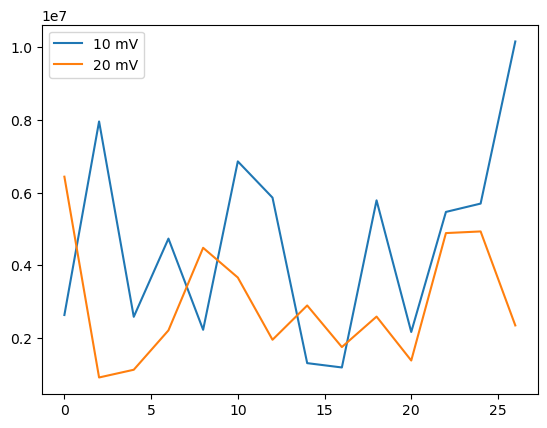

In [97]:
fig, ax = plt.subplots()

EIS_10_results_df["Rp"].plot(ax=ax, label="10 mV")
EIS_20_results_df["Rp"].plot(ax=ax, label="20 mV")
ax.legend()

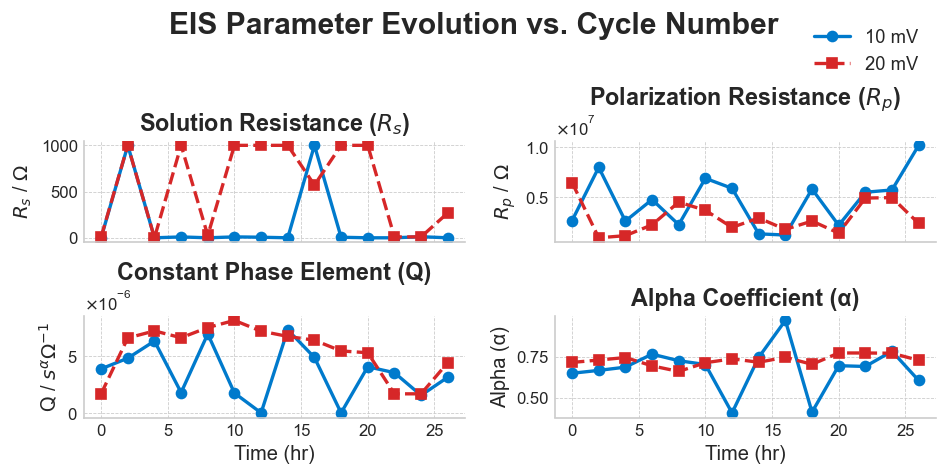

In [104]:

# 1. Set a professional style
plt.style.use('seaborn-v0_8-whitegrid')

# 2. Create a 2x2 grid of subplots
# `sharex=True` links the x-axes for easier comparison.
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 4), dpi=120, sharex=True)

# Flatten the 2x2 array of axes to easily loop through them
axes = axes.flatten()

# 3. Define parameters and labels for each subplot
params = ['Rs', 'Rp', 'Q', 'alpha']
titles = [
    'Solution Resistance ($R_s$)',
    'Polarization Resistance ($R_p$)',
    'Constant Phase Element (Q)',
    'Alpha Coefficient (α)'
]
ylabels = [
    '$R_s$ / $\\Omega$',
    '$R_p$ / $\\Omega$',
    'Q / $s^{\\alpha} \\Omega^{-1}$',
    'Alpha (α)'
]

# 4. Loop through each parameter and create a subplot
for i, ax in enumerate(axes):
    param = params[i]

    # Plot data from both DataFrames on the current axis
    ax.plot(EIS_10_results_df.index, EIS_10_results_df[param],
            label="10 mV", marker='o', linestyle='-', linewidth=2, color='#007ACC')

    ax.plot(EIS_20_results_df.index, EIS_20_results_df[param],
            label="20 mV", marker='s', linestyle='--', linewidth=2, color='#D62728')

    # Customize titles and labels for each subplot
    ax.set_title(titles[i], fontsize=14, fontweight='bold')
    ax.set_ylabel(ylabels[i], fontsize=12)

    # Customize grid and spines
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='both', which='major', labelsize=10)

    # Apply scientific notation where needed (e.g., for Rp and Q)
    if param in ['Rp', 'Q']:
        ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)
        ax.yaxis.get_offset_text().set_fontsize(10)

# 5. Global customizations
# Add a shared x-axis label to the bottom plots
axes[2].set_xlabel('Time (hr)', fontsize=12)
axes[3].set_xlabel('Time (hr)', fontsize=12)

# Create a single, shared legend for the entire figure
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', fontsize=11, bbox_to_anchor=(0.98, 0.98))

# Add a main title for the whole figure
fig.suptitle('EIS Parameter Evolution vs. Cycle Number', fontsize=18, fontweight='bold')

# 6. Adjust layout to prevent titles/labels from overlapping
fig.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust rect to make space for suptitle

# 7. Show the plot
plt.show()